In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import math

import yfinance as yf

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
# import Infosys data
infy_data = yf.Ticker("INFY")
infy_df = infy_data.history(period="max")

In [5]:
infy_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-03-11 00:00:00-05:00,0.385778,0.516091,0.385778,0.483835,172512000,0.0,0.0
1999-03-12 00:00:00-05:00,0.485125,0.503189,0.443838,0.481255,39897600,0.0,0.0
1999-03-15 00:00:00-05:00,0.482545,0.482545,0.434807,0.437387,12672000,0.0,0.0
1999-03-16 00:00:00-05:00,0.441258,0.456740,0.433516,0.433516,9984000,0.0,0.0
1999-03-17 00:00:00-05:00,0.433516,0.461902,0.430936,0.436097,15449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-18 00:00:00-04:00,19.190001,19.230000,19.070000,19.170000,6324200,0.0,0.0
2024-03-19 00:00:00-04:00,18.690001,18.850000,18.629999,18.850000,9561000,0.0,0.0
2024-03-20 00:00:00-04:00,18.670000,18.930000,18.639999,18.930000,9677300,0.0,0.0


In [6]:
# removing dividends and stock splits columns
infy_df.drop(columns=["Dividends", "Stock Splits"])

# removing last 30 days data
# df = infy_df[infy_df.index < infy_df.index[-1] - pd.Timedelta(30, 'D')]

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-11 00:00:00-05:00,0.385778,0.516091,0.385778,0.483835,172512000
1999-03-12 00:00:00-05:00,0.485125,0.503189,0.443838,0.481255,39897600
1999-03-15 00:00:00-05:00,0.482545,0.482545,0.434807,0.437387,12672000
1999-03-16 00:00:00-05:00,0.441258,0.456740,0.433516,0.433516,9984000
1999-03-17 00:00:00-05:00,0.433516,0.461902,0.430936,0.436097,15449600
...,...,...,...,...,...
2024-03-18 00:00:00-04:00,19.190001,19.230000,19.070000,19.170000,6324200
2024-03-19 00:00:00-04:00,18.690001,18.850000,18.629999,18.850000,9561000
2024-03-20 00:00:00-04:00,18.670000,18.930000,18.639999,18.930000,9677300


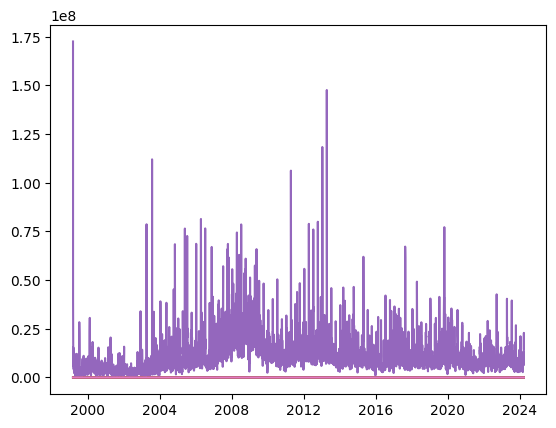

In [7]:
# plotting the stock
plt.plot(infy_df)

In [8]:
close_data_infy = infy_df["Close"]

close_data_infy

Date
1999-03-11 00:00:00-05:00     0.483835
1999-03-12 00:00:00-05:00     0.481255
1999-03-15 00:00:00-05:00     0.437387
1999-03-16 00:00:00-05:00     0.433516
1999-03-17 00:00:00-05:00     0.436097
                               ...    
2024-03-18 00:00:00-04:00    19.170000
2024-03-19 00:00:00-04:00    18.850000
2024-03-20 00:00:00-04:00    18.930000
2024-03-21 00:00:00-04:00    18.209999
2024-03-22 00:00:00-04:00    17.719999
Name: Close, Length: 6300, dtype: float64

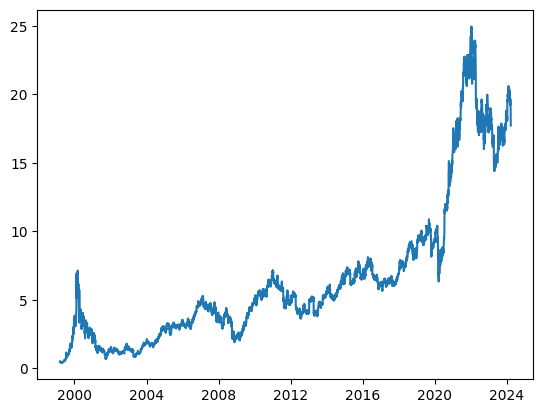

In [9]:
# plotting the price of stock on closing time
plt.plot(close_data_infy)

In [10]:
# real-valued data to discreet-valued data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(close_data_infy).reshape(-1, 1))

In [11]:
for i in df:
    print(i)

[0.0028904]
[0.0027853]
[0.0009985]
[0.00084084]
[0.00094595]
[0.00126126]
[0.00084084]
[0.00094595]
[0.00015765]
[0.00031533]
[0.00094595]
[0.00225976]
[0.00246998]
[0.00225976]
[0.00131381]
[0.00073574]
[0.00147149]
[0.00070945]
[0.00126126]
[0.001997]
[0.00168169]
[0.00160285]
[0.00078829]
[0.00078829]
[0.00078829]
[0.00147149]
[0.00084084]
[0.0001051]
[0.]
[0.00136636]
[0.00110362]
[0.00089339]
[0.]
[0.]
[0.0001051]
[0.0005518]
[0.00084084]
[0.0006832]
[0.00086713]
[0.00120872]
[0.00173424]
[0.00120872]
[0.00110362]
[0.00126126]
[0.00168169]
[0.00157659]
[0.0014452]
[0.00084084]
[0.00126126]
[0.00236488]
[0.00257507]
[0.00310059]
[0.00404656]
[0.00436186]
[0.00399401]
[0.00409911]
[0.00421182]
[0.00415924]
[0.00400154]
[0.00405411]
[0.00494783]
[0.00678782]
[0.00389638]
[0.00547354]
[0.0055261]
[0.00592041]
[0.0050004]
[0.0058941]
[0.00652498]
[0.00852268]
[0.00825983]
[0.00652498]
[0.00783927]
[0.0075764]
[0.00815468]
[0.0075764]
[0.00762897]
[0.0075764]
[0.0075764]
[0.00731354]
[

In [12]:
# dividing data into training and testing sets
training_size = int(len(df)*0.7)
testing_size = int(len(df)) - training_size

print(f"Training size: {training_size} and testing size: {testing_size}")

Training size: 4410 and testing size: 1890


In [13]:
training_data, testing_data = df[0:training_size:], df[training_size:len(df):]

In [14]:
for i in training_data:
    print(i)

[0.0028904]
[0.0027853]
[0.0009985]
[0.00084084]
[0.00094595]
[0.00126126]
[0.00084084]
[0.00094595]
[0.00015765]
[0.00031533]
[0.00094595]
[0.00225976]
[0.00246998]
[0.00225976]
[0.00131381]
[0.00073574]
[0.00147149]
[0.00070945]
[0.00126126]
[0.001997]
[0.00168169]
[0.00160285]
[0.00078829]
[0.00078829]
[0.00078829]
[0.00147149]
[0.00084084]
[0.0001051]
[0.]
[0.00136636]
[0.00110362]
[0.00089339]
[0.]
[0.]
[0.0001051]
[0.0005518]
[0.00084084]
[0.0006832]
[0.00086713]
[0.00120872]
[0.00173424]
[0.00120872]
[0.00110362]
[0.00126126]
[0.00168169]
[0.00157659]
[0.0014452]
[0.00084084]
[0.00126126]
[0.00236488]
[0.00257507]
[0.00310059]
[0.00404656]
[0.00436186]
[0.00399401]
[0.00409911]
[0.00421182]
[0.00415924]
[0.00400154]
[0.00405411]
[0.00494783]
[0.00678782]
[0.00389638]
[0.00547354]
[0.0055261]
[0.00592041]
[0.0050004]
[0.0058941]
[0.00652498]
[0.00852268]
[0.00825983]
[0.00652498]
[0.00783927]
[0.0075764]
[0.00815468]
[0.0075764]
[0.00762897]
[0.0075764]
[0.0075764]
[0.00731354]
[

In [15]:
for i in testing_data:
    print(i)

[0.25256714]
[0.25123108]
[0.25256714]
[0.25457126]
[0.24972802]
[0.24822494]
[0.24889296]
[0.24855894]
[0.24822494]
[0.24672185]
[0.24972802]
[0.24956105]
[0.24972802]
[0.24638787]
[0.2437157]
[0.24822494]
[0.24538582]
[0.249227]
[0.26125156]
[0.24471773]
[0.24538582]
[0.24889296]
[0.25049615]
[0.24880859]
[0.25100245]
[0.25302756]
[0.24796479]
[0.24678348]
[0.24239581]
[0.24121449]
[0.24070819]
[0.24070819]
[0.2390206]
[0.23564547]
[0.23699552]
[0.24037065]
[0.2390206]
[0.22855764]
[0.22687001]
[0.22805133]
[0.22045721]
[0.21944467]
[0.22130102]
[0.22113226]
[0.21758835]
[0.21944467]
[0.22045721]
[0.22163854]
[0.22838886]
[0.2288951]
[0.22788259]
[0.22754509]
[0.22467621]
[0.22467621]
[0.22518245]
[0.22737631]
[0.23277655]
[0.23260779]
[0.23193276]
[0.23125776]
[0.23581419]
[0.23362035]
[0.23429541]
[0.23463289]
[0.23412663]
[0.23513923]
[0.23581419]
[0.23294535]
[0.23210155]
[0.23311407]
[0.23176404]
[0.23193276]
[0.23345159]
[0.23193276]
[0.23851438]
[0.23665802]
[0.23328281]
[0.23

In [16]:
print(f"Length of training set: {len(training_data)}, calculated length: {training_size}")
print(f"Length of testing set: {len(testing_data)}, calculated length: {testing_size}")

Length of training set: 4410, calculated length: 4410
Length of testing set: 1890, calculated length: 1890


In [17]:
# creating datasets for predictions
def create_datasets(dataset, timesteps=1):
    data_x, data_y = [], []

    for i in range(len(dataset)-timesteps):
        data = dataset[i:(timesteps+i), 0]
        data_x.append(data)
        prev_data = dataset[i+timesteps, 0]
        data_y.append(prev_data)

    return np.array(data_x), np.array(data_y)

In [18]:
train_x, train_y = create_datasets(training_data, 250)
test_x, test_y = create_datasets(testing_data, 250)

In [19]:
train_x, train_y

(array([[0.0028904 , 0.0027853 , 0.0009985 , ..., 0.23744905, 0.25953175,
         0.27341223],
        [0.0027853 , 0.0009985 , 0.00084084, ..., 0.25953175, 0.27341223,
         0.26499978],
        [0.0009985 , 0.00084084, 0.00094595, ..., 0.27341223, 0.26499978,
         0.26920598],
        ...,
        [0.27380672, 0.26840361, 0.27560787, ..., 0.25156513, 0.25674235,
         0.25139808],
        [0.26840361, 0.27560787, 0.27380672, ..., 0.25674235, 0.25139808,
         0.24956105],
        [0.27560787, 0.27380672, 0.27216941, ..., 0.25139808, 0.24956105,
         0.25106407]]),
 array([0.26499978, 0.26920598, 0.26920598, ..., 0.24956105, 0.25106407,
        0.25156513]))

In [20]:
test_x, test_y

(array([[0.25256714, 0.25123108, 0.25256714, ..., 0.23227789, 0.23210655,
         0.23244917],
        [0.25123108, 0.25256714, 0.25457126, ..., 0.23210655, 0.23244917,
         0.23416233],
        [0.25256714, 0.25457126, 0.24972802, ..., 0.23244917, 0.23416233,
         0.23673212],
        ...,
        [0.64171193, 0.65519987, 0.6496459 , ..., 0.76644629, 0.76400243,
         0.75096843],
        [0.65519987, 0.6496459 , 0.65837346, ..., 0.76400243, 0.75096843,
         0.75422693],
        [0.6496459 , 0.65837346, 0.64845586, ..., 0.75096843, 0.75422693,
         0.72490033]]),
 array([0.23416233, 0.23673212, 0.23673212, ..., 0.75422693, 0.72490033,
        0.704942  ]))

In [21]:
train_x.shape, train_y.shape

((4160, 250), (4160,))

In [22]:
# reshape data into (batch size, timesteps, features)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

In [23]:
train_x

array([[[0.0028904 ],
        [0.0027853 ],
        [0.0009985 ],
        ...,
        [0.23744905],
        [0.25953175],
        [0.27341223]],

       [[0.0027853 ],
        [0.0009985 ],
        [0.00084084],
        ...,
        [0.25953175],
        [0.27341223],
        [0.26499978]],

       [[0.0009985 ],
        [0.00084084],
        [0.00094595],
        ...,
        [0.27341223],
        [0.26499978],
        [0.26920598]],

       ...,

       [[0.27380672],
        [0.26840361],
        [0.27560787],
        ...,
        [0.25156513],
        [0.25674235],
        [0.25139808]],

       [[0.26840361],
        [0.27560787],
        [0.27380672],
        ...,
        [0.25674235],
        [0.25139808],
        [0.24956105]],

       [[0.27560787],
        [0.27380672],
        [0.27216941],
        ...,
        [0.25139808],
        [0.24956105],
        [0.25106407]]])

In [24]:
# building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.add(Activation("relu"))

c:\Users\Mehul\CODES\StockPrediction-Minor\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [27]:
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=200, batch_size=64, verbose=1)

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - accuracy: 0.0000e+00 - loss: 0.0034 - val_accuracy: 6.0976e-04 - val_loss: 0.0029
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.0000e+00 - loss: 1.2895e-04 - val_accuracy: 6.0976e-04 - val_loss: 0.0026
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.0000e+00 - loss: 1.2558e-04 - val_accuracy: 6.0976e-04 - val_loss: 0.0023
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 423ms/step - accuracy: 0.0000e+00 - loss: 1.2276e-04 - val_accuracy: 6.0976e-04 - val_loss: 0.0015
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.0000e+00 - loss: 1.1772e-04 - val_accuracy: 6.0976e-04 - val_loss: 0.0017
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.0000e+00 - loss: 9.3813e-05 - val_accuracy: 6.0976e-04 - val_loss: 0.0014
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - accuracy: 0.0000e+00 - loss: 1.0793e-04 - val_accuracy: 6.0976e-04 - val_loss: 0.0011
Epoch 8/20

In [28]:
# predicting data
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step


In [29]:
train_predict

array([[0.27228683],
       [0.26279452],
       [0.2669177 ],
       ...,
       [0.25197184],
       [0.25033638],
       [0.2520289 ]], dtype=float32)

In [30]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [31]:
train_predict

array([[7.0978236],
       [6.864777 ],
       [6.966006 ],
       ...,
       [6.5990677],
       [6.558915 ],
       [6.600469 ]], dtype=float32)

In [33]:
mse = mean_squared_error(train_y, train_predict)
rmse = np.sqrt(mse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [46.68748  43.501556 44.847126 ... 40.31624  39.788982 40.308582]
Root mean squared error: [6.8328238 6.595571  6.6967998 ... 6.349507  6.307851  6.348904 ]


In [34]:
mse = mean_squared_error(test_y, test_predict)
rmse = np.sqrt(rmse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [ 34.917217  35.381252  36.117638 ... 265.32     266.2639   254.16653 ]
Root mean squared error: [2.613967  2.5681844 2.5878177 ... 2.5198228 2.5115435 2.5197031]


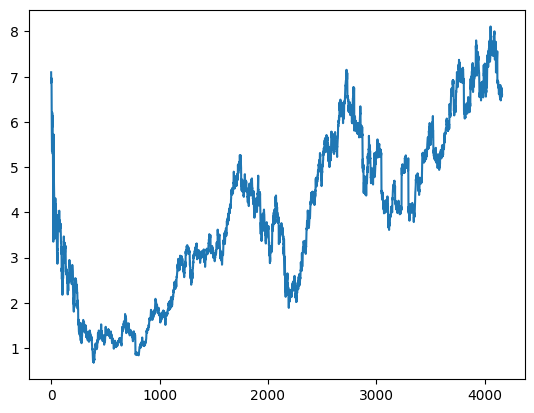

In [39]:
plt.plot(train_predict)